In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype
from sklearn import preprocessing

In [2]:
# Read data
datadir = os.getcwd()
data = pd.read_csv(datadir + '/' + 'WA_Fn-UseC_-HR-Employee-Attrition.csv')
# Do some cleaning
# Firstly, make the attrition column numeric, so that 1 for 'yes' and 0 for 'no'
data_clean = data.copy()
Attrition_result = np.array((data_clean['Attrition'] == 'Yes').astype(int))
data_clean = data_clean.drop(['Attrition'], axis = 1)
# Now we check if we have any null value in our dataset
if data_clean.isnull().any().any():
    print('No!!!!!!!!!!')
# Gladly, we don't have any null value, so now let's do something about categorical variable
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop(col, axis = 1)
# Now do some preprocessing so that all the features in our dataset have mean 0 and std 1 for
#      future convenience
scale = preprocessing.StandardScaler()
data_clean = pd.DataFrame(scale.fit_transform(data_clean), columns = data_clean.columns)
data_clean['Attrition'] = Attrition_result

In [3]:
# So our dataset will look like this
data_clean.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole Laboratory Technician indicator,JobRole Sales Executive indicator,JobRole Healthcare Representative indicator,MaritalStatus Married indicator,MaritalStatus Divorced indicator,MaritalStatus Single indicator,Over18 Y indicator,OverTime No indicator,OverTime Yes indicator,Attrition
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,...,-0.462464,1.873287,-0.312785,-0.918921,-0.534873,1.458650,0.0,-1.591746,1.591746,1
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,...,-0.462464,-0.533821,-0.312785,1.088232,-0.534873,-0.685565,0.0,0.628241,-0.628241,0
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,...,2.162331,-0.533821,-0.312785,-0.918921,-0.534873,1.458650,0.0,-1.591746,1.591746,1
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,...,-0.462464,-0.533821,-0.312785,1.088232,-0.534873,-0.685565,0.0,-1.591746,1.591746,0
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,...,2.162331,-0.533821,-0.312785,1.088232,-0.534873,-0.685565,0.0,0.628241,-0.628241,0


In [4]:
# Now build some baseline model for predicting attrition
# Since this is just a baseline model, split data into 80%, 20% so that the first part would be
#      used for training and the later part would be used for testing
train_index = []
test_index = []
length = len(data_clean['Attrition'])
for i in range(0, length):
    train_index.append(i) if np.random.rand() <= 0.8 else test_index.append(i)
data_train = data_clean.iloc[train_index, :]
data_test = data_clean.iloc[test_index, :]

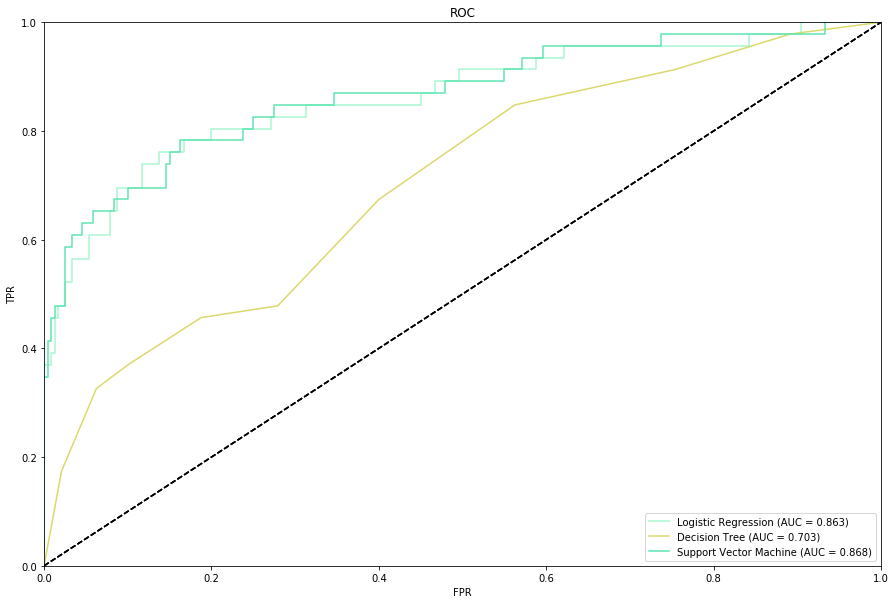

In [5]:
# I want to try logistic regression, decision tree, support vector machine
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
%matplotlib inline

# Build models and predict
# Logistic regression
lg = linear_model.LogisticRegression(C = 1e30)
lg.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_lg = lg.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Decision Tree
DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 200, min_samples_leaf = 20)
DT.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_DT = DT.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Support vector machine
our_svm = svm.SVC(kernel = 'linear')
our_svm.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_svm = our_svm.decision_function(data_test.drop(['Attrition'], axis = 1))

def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

# Plot ROC for logistic regression
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['Attrition'], 'Logistic Regression')
plotROC(result_DT, data_test['Attrition'], 'Decision Tree')
plotROC(result_svm, data_test['Attrition'], 'Support Vector Machine')
plt.show()

So here is our baseline model, it looks like logistic regression and support vector machine did pretty similar job while decition tree is doing badly, this may be the result that I chose the wrong paramter, which we'll try to fix it later.<br>
Ok so for next step, try to find the best parameter and also make some plot for the relationships between features.<br>
I'll start with finding best parameter.

In [6]:
# Since we have limited amount of samples, we better use cross validation to find the best parameter
from sklearn.model_selection import KFold
def find_best_parameter(k, cs, lgc, min_split_values, min_leaf_values):
    # Note that 'k' is for deciding how many folders do we want to use, 'cs' is a list for
    #      parameters for support vector machine we want to try, 'lgc' is a list for parameters
    #      of logistic regression and the last two are both for decision tree
    # Create a KFold using parameter k and create an empty dictionary
    KF = KFold(n_splits = k)
    aucs_dt = {}
    aucs_svm = {}
    aucs_lg = {}
    # Dividing dataset by folds
    for train_ind, test_ind in KF.split(data_clean):
        cv_train = data_clean.iloc[train_ind]
        cv_validate = data_clean.iloc[test_ind]
        # Find best parameter for Decision Tree
        # Calculate roc_auc_score for different parameters and store them in the dictionary
        count = len(min_split_values)
        for i in range(0, count):
            for j in range(0, count):
            # Construct a decision tree for each set of values
                dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_split_values[i],
                                   min_samples_leaf = min_leaf_values[j])
                dt.fit(cv_train.drop('Attrition', 1), cv_train['Attrition'])
                Attrition_DT = dt.predict_proba(cv_validate.drop(['Attrition'], axis = 1))[:, 1]
                aucdt = roc_auc_score(cv_validate['Attrition'], Attrition_DT)
                key = (' ').join([str(min_split_values[i]), str(min_leaf_values[j])])
                # Put on some tracker
                print(key)
                if key in aucs_dt:
                    aucs_dt[key].append(aucdt)
                else:
                    aucs_dt[key] = [aucdt]
        # Find best parameter for support vector machine
        for c in cs:
            new_svm = svm.SVC(C = c, kernel = "linear", gamma = 'auto')
            new_svm.fit(cv_train.drop(['Attrition'], axis = 1), cv_train['Attrition'])
            aucsvm = roc_auc_score(cv_validate['Attrition'], 
                                    new_svm.decision_function(cv_validate.drop(['Attrition'], axis = 1)))
            print(c)
            if c in aucs_svm:
                aucs_svm[c].append(aucsvm)
            else:
                aucs_svm[c] = [aucsvm]
        # Find best parameter for logistic regression
        for c in lgc:
            new_lg = linear_model.LogisticRegression(C = c)
            new_lg.fit(cv_train.drop(['Attrition'], axis = 1), cv_train['Attrition'])
            print(c)
            auclg = roc_auc_score(cv_validate['Attrition'], 
                                    new_lg.predict_proba(cv_validate.drop(['Attrition'], axis = 1))[:, 1])
            if c in aucs_lg:
                aucs_lg[c].append(auclg)
            else:
                aucs_lg[c] = [auclg]
    return [aucs_dt, aucs_svm, aucs_lg]

In [ ]:
# Find them!
min_samples_split_values = []
min_samples_leaf_values = []
for i in range(1, 31):
    min_samples_split_values.append(50 * i)
    min_samples_leaf_values.append(5 * i)
cs = [10 ** i for i in range(-7, 3)]
lgc = [10 ** i for i in range(0, 30)]
aucs = find_best_parameter(10, cs, lgc, min_samples_split_values, min_samples_leaf_values)

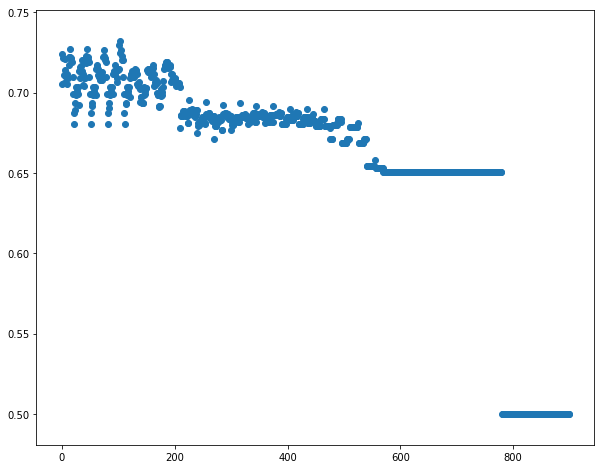

In [8]:
dt_pa = aucs[0]
svm_pa = aucs[1]
lg_pa = aucs[2]
dt_parameter = [np.mean(dt_pa[key]) for key in dt_pa]
svm_parameter = [np.mean(svm_pa[key]) for key in svm_pa]
lg_parameter = [np.mean(lg_pa[key]) for key in lg_pa]
# Now make some plot
# Firstly, plot for results in decision tree and paramter
fig = plt.figure(figsize = (10,8))
plt.scatter(range(0, len(dt_parameter)), dt_parameter)
plt.show()

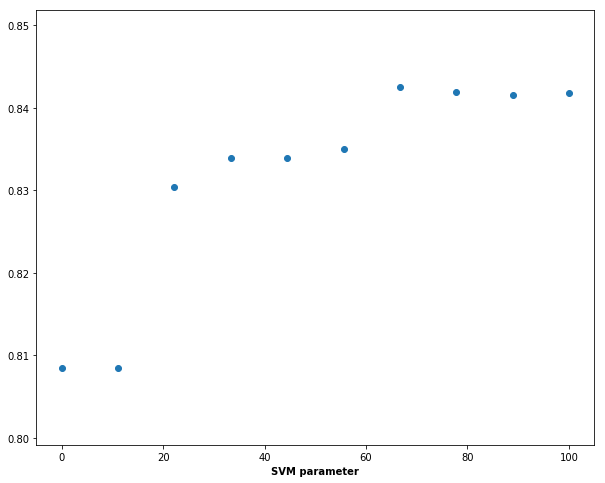

In [9]:
# Secondly, plot for results in svm and paramter
fig = plt.figure(figsize = (10,8))
plt.scatter(np.linspace(cs[0], cs[-1], 10), svm_parameter)
plt.xlabel('SVM parameter', fontweight='bold')
# ax.set_xticks(np.linspace(cs[0], cs[-1], 10))
# ax.set_xticklabels(cs)
plt.show()

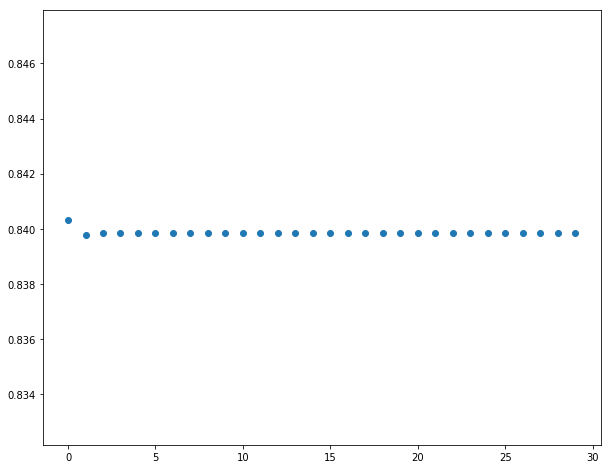

In [10]:
# Thirdly, plot for results in logistic regression and paramter
fig = plt.figure(figsize = (10,8))
plt.scatter(range(0, len(lg_parameter)), lg_parameter)
plt.show()

In [11]:
# Find the best parameter
bestkey_dt = list(dt_pa.keys())[np.argmax(dt_parameter)]
bestkey_dt

'200 70'

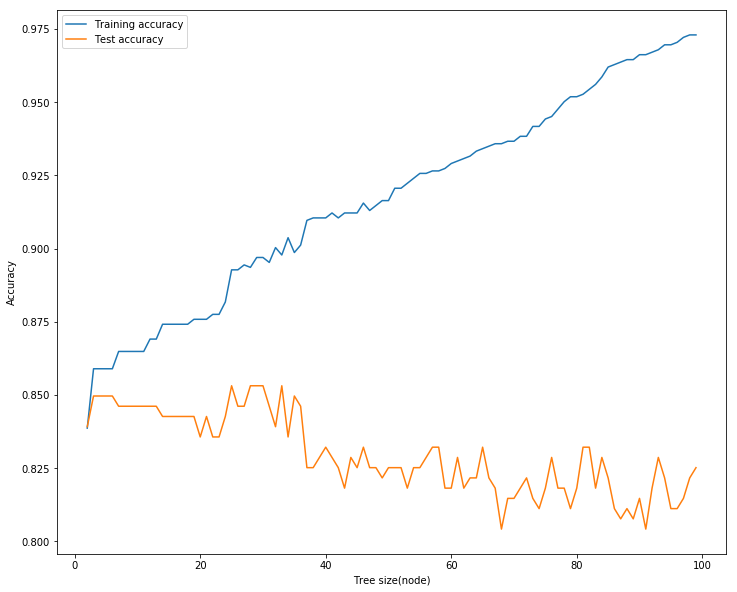

In [12]:
# Here I provide a plot for relationship between tree nodes in decision tree and the accuracy
# We could do the same for svm and logistic regression as well, but since I'm lazy, I'll only do decision tree...
from sklearn.metrics import accuracy_score
acc_train = []
acc_test = []
for i in range(2, 100):
    dt_plot = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = i)
    dt_plot.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
    acc_train.append(accuracy_score(data_train['Attrition'], 
                                    dt_plot.predict(data_train.drop(['Attrition'], axis = 1))))
    acc_test.append(accuracy_score(data_test['Attrition'], 
                                    dt_plot.predict(data_test.drop(['Attrition'], axis = 1))))
x_axis = np.array(range(2, 100))
fig_dt = plt.figure(figsize = (12,10))
plt.plot(x_axis, acc_train, label = 'Training accuracy')
plt.plot(x_axis, acc_test, label = 'Test accuracy')
plt.xlabel("Tree size(node)")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In this particular dataset, we have testing accuracy and training accuracy diverges started at the very first.

In [22]:
# Find mutual information between features and target variables(this gives us hint about which features
#     predict the target variable well)
from sklearn.feature_selection import mutual_info_classif as mic
mi_list = mic(data_clean.drop('Attrition', axis = 1).values, data_clean['Attrition'].values)
col_list = list(data_clean.columns)
col_list.remove('Attrition')
mi_dict = dict(zip(col_list, list(mi_list)))
mi_dict

{'Age': 0.04258877148688356,
 'DailyRate': 0.0,
 'DistanceFromHome': 0.006539564602187742,
 'Education': 0.0,
 'EmployeeCount': 0.0017819045219036322,
 'EmployeeNumber': 0.006688878230657336,
 'EnvironmentSatisfaction': 0.015989794451140238,
 'HourlyRate': 0.0,
 'JobInvolvement': 0.00797562652432715,
 'JobLevel': 0.03487157610636338,
 'JobSatisfaction': 0.011987258220820918,
 'MonthlyIncome': 0.032366962061439075,
 'MonthlyRate': 0.0025777234047916764,
 'NumCompaniesWorked': 0.015102197316415156,
 'PercentSalaryHike': 0.01225779548311956,
 'PerformanceRating': 0.009630780584397813,
 'RelationshipSatisfaction': 0.0029298775545401057,
 'StandardHours': 0.015247906249457932,
 'StockOptionLevel': 0.03220016304827755,
 'TotalWorkingYears': 0.019956177194461855,
 'TrainingTimesLastYear': 0.0,
 'WorkLifeBalance': 0.005208117776774657,
 'YearsAtCompany': 0.01741747644737668,
 'YearsInCurrentRole': 0.005641308798484346,
 'YearsSinceLastPromotion': 0.011676841803990756,
 'YearsWithCurrManager': 